In [1]:
from base import ComputationalGraphs as cg

In [2]:
a = cg.Edge(value=5, name='a')
b = cg.Edge(value=3, name='b')
c = cg.Edge(value=2, name='c')
const = cg.Edge(3, 'const')

In [3]:
u = b*c
u.name = 'u'
u.history['*'] = (b, c)
v = a + u
v.name = 'v'
v.history['+'] = (a, u)
J = const*v
J.history['*'] = (const, v)
J.name = 'J'

In [4]:
vars = [u, v, J]

In [5]:
u, v, J

(u = 6, v = 11, J = 33)

In [6]:
gradients = cg.get_gradients(J)

In [7]:
gradients

defaultdict(<function base.ComputationalGraphs.get_gradients.<locals>.<lambda>()>,
            {const = 3: 11, v = 11: 3, a = 5: 3, u = 6: 3, b = 3: 6, c = 2: 9})

In [8]:
a.history, b.history, c.history, u.history, v.history

({'+': (a = 5.0, (b*c) = 6.0)},
 {'*': (b = 3.0, c = 2.0)},
 {},
 {'*': (b = 3, c = 2)},
 {'+': (a = 5, u = 6)})

In [9]:
a.src, J.src

(a = 5.0, (const*v) = 33.0)

In [10]:
import networkx as nx

In [11]:
a.history, b.history

({'+': (a = 5.0, (b*c) = 6.0)}, {'*': (b = 3.0, c = 2.0)})

In [12]:
g =  nx.Graph()
for var in vars:
    cont = list(var.history.values())
    for i, (v1, v2) in enumerate(cont):
        g.add_edge(v1, v2)
                

In [13]:
print(g.edges)

[(b = 3, c = 2), (a = 5, u = 6), (const = 3, v = 11)]


In [14]:
import matplotlib.pyplot as plt

In [15]:
g.add_edge(b, u)
g.add_edge(c, u)
g.add_edge(a, v)
g.add_edge(const, v)

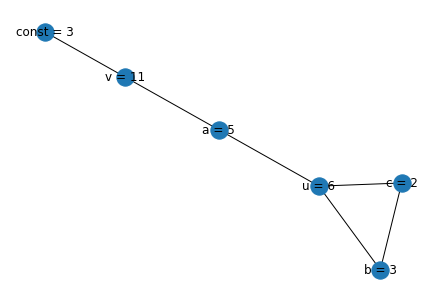

In [16]:
nx.draw(g, with_labels=True)
plt.savefig("test.png")

In [17]:
operations_dict = {(0, 'u'): (b, c, cg.mul), (1, 'v'): (a, u, cg.add), (2, 'J'): (const, v, cg.mul)}

In [18]:
temp = cg.add(a, u)
temp.name = 'v'

In [19]:
type(v)

base.ComputationalGraphs.Edge

In [20]:
class Plotter:
    def __init__(self, base_vars=None):
        self.base_vars = base_vars
        self.expns = []
        
    def perform_ops(self, operations_dict: dict):
        for var, (a, b, fun) in operations_dict.items():
            print(a, b, fun)
            temp = fun(a, b)
            temp.name = var
            self.expns.append(temp)
        
        print(self.expns)

In [21]:
p = Plotter()

In [22]:
p.perform_ops(operations_dict)

b = 3 c = 2 <function mul at 0x7fa6abb66e50>
a = 5 u = 6 <function add at 0x7fa6ab8e4670>
const = 3 v = 11 <function mul at 0x7fa6abb66e50>
[(0, 'u') = 6, (1, 'v') = 11, (2, 'J') = 33]


In [23]:
p.expns

[(0, 'u') = 6, (1, 'v') = 11, (2, 'J') = 33]

In [24]:
import pydantic
import numpy as np
import networkx as nx
import matplotlib as mpl
from collections import defaultdict
from base import ComputationalGraphs as cg

In [25]:
a = cg.Edge(value=5, name='a')
b = cg.Edge(value=3, name='b')
c = cg.Edge(value=2, name='c')
const = cg.Edge(3, 'const')

d = b*c
d.name = 'd'
d.history['*'] = (b, c)
e = a + d
e.name = 'e'
e.history['+'] = (a, d)
f = e*const
f.history['*'] = (const, e)
f.name = 'f'

In [26]:
class Node(pydantic.BaseModel):
    """A dataclass representing a base variable"""
    value: float
    name: str
    
    def __repr__(self) -> str:
        return "{} = {}".format(self.name, self.value)
    
    def __str__(self) -> str:
        return repr(self)

In [27]:
a = cg.Edge(value=5, name='a')
b = cg.Edge(value=3, name='b')
c = cg.Edge(value=2, name='c')
const = cg.Edge(3, 'const')

operations_dict = {(0, 'd'): (b, c, cg.mul), (1, 'e'): (a, d, cg.add), (2, 'f'): (e, const, cg.mul)}

In [59]:
class Plotter:
    def __init__(self, base_vars:list):
        self.base_vars = base_vars
        self.vars = {}
        for v in self.base_vars:
            self.vars[v.name] = v
        self.expns = []
        self.graph = nx.DiGraph()
        
    def perform_ops(self, operations_dict: dict):
        self.operations_dict = operations_dict
        
        for var, (a, b, fun) in operations_dict.items():
            print(a, b, fun)
            if a not in self.vars:
                self.vars[a.name] = a
            if b not in self.vars:
                self.vars[b.name] = b
                
            temp = fun(a, b, name=var[1])
            self.expns.append(temp)
        
        self.vars[self.expns[-1].name] = self.expns[-1]
        print(self.vars)
        
    def create_network(self):
        for i, v in self.operations_dict.items():
            x, y, _ = v
            u1idx = x.name
            u2idx = y.name
            adder = len(self.base_vars)
            self.graph.add_edge(u1idx, i[1])
            self.graph.add_edge(u2idx, i[1])
            
    def plot(self):
        M = self.graph.number_of_edges()
        node_sizes = [3 + 10 * i for i in range(len(self.graph))]
        seed=42
        pos = nx.spring_layout(self.graph, seed=seed)
        edge_colors = range(2, M + 2)
        edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
        cmap = plt.cm.plasma

        plt.figure(figsize=(12, 12))
        nodes = nx.draw_networkx_nodes(self.graph, pos, node_size=1000, node_color="indigo")
        edges = nx.draw_networkx_edges(
            self.graph,
            pos,
            node_size=node_sizes,
            arrowstyle="->",
            arrowsize=10,
            edge_color=edge_colors,
            edge_cmap=cmap,
            width=2,
        )

        for i in range(M):
            edges[i].set_alpha(edge_alphas[i])
            
        pc = mpl.collections.PatchCollection(edges, cmap=cmap)
        pc.set_array(edge_colors)
        plt.colorbar(pc)

        labels = {}
        for name, var in self.vars.items():
            if 'const' in name:
                labels[name] = f"{var.value}"        
            labels[name] = fr"${name}$"
            
        nx.draw_networkx_labels(self.graph, pos, labels, font_size=22, font_color="whitesmoke")

        ax = plt.gca()
        ax.set_axis_off()
        plt.show()
                

True


In [60]:
p = Plotter([a, b, c])

p.perform_ops(operations_dict)

b = 3 c = 2 <function mul at 0x7fa6abb66e50>
a = 5 d = 6 <function add at 0x7fa6ab8e4670>
e = 11 const = 3 <function mul at 0x7fa6abb66e50>
{'a': a = 5, 'b': b = 3, 'c': c = 2, 'd': d = 6, 'e': e = 11, 'const': const = 3, 'f': f = 33}


In [61]:
p.create_network()

/tmp/ipykernel_23805/3750278.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


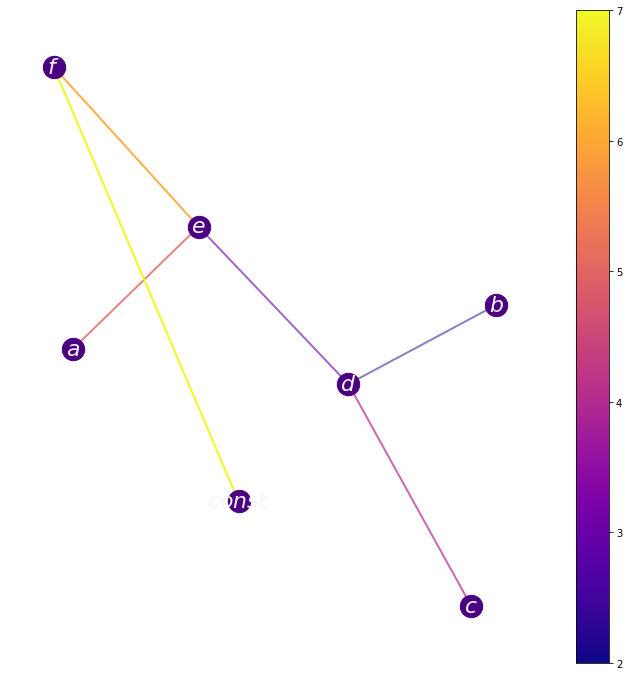

In [62]:
p.plot()

In [35]:
p.graph.edges

OutEdgeView([('b', 'd'), ('d', 'e'), ('c', 'd'), ('a', 'e'), ('e', 'f'), ('const', 'f')])

In [ ]:
G = nx.DiGraph()
G.add_edge(1, 5)
G.add_edge(2, 4)
G.add_edge(3, 4)
G.add_edge(4, 5)
G.add_edge(5, 6)


/tmp/ipykernel_23805/2472077120.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


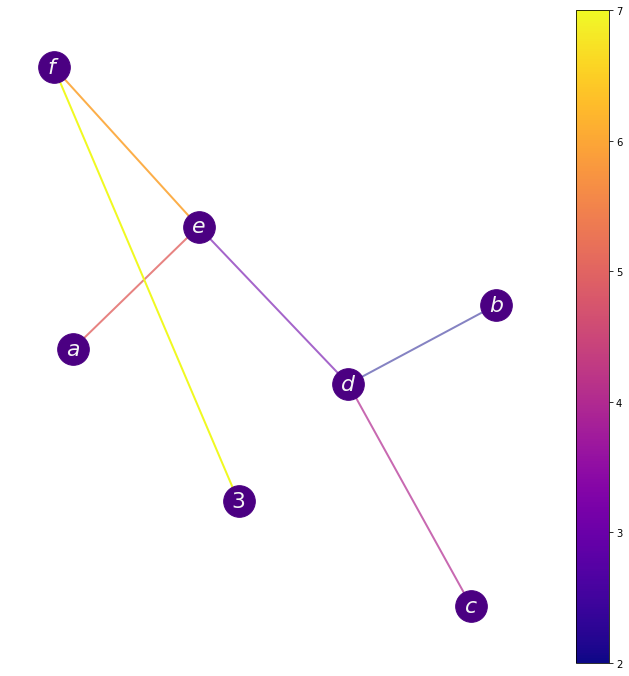

In [41]:
M = p.graph.number_of_edges()
node_sizes = [3 + 10 * i for i in range(len(p.graph))]
seed=42
pos = nx.spring_layout(p.graph, seed=seed)
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(p.graph, pos, node_size=1000, node_color="indigo")
edges = nx.draw_networkx_edges(
    p.graph,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)

for i in range(M):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

labels = {}
labels['a'] = r"$a$"
labels['b'] = r"$b$"
labels['c'] = r"$c$"
labels['d'] = r"$d$"
labels['e'] = r"$e$"
labels['f'] = r"$f$"
labels['const'] = r"$3$"
nx.draw_networkx_labels(p.graph, pos, labels, font_size=22, font_color="whitesmoke")

ax = plt.gca()
ax.set_axis_off()
plt.show()

/tmp/ipykernel_15753/452667133.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


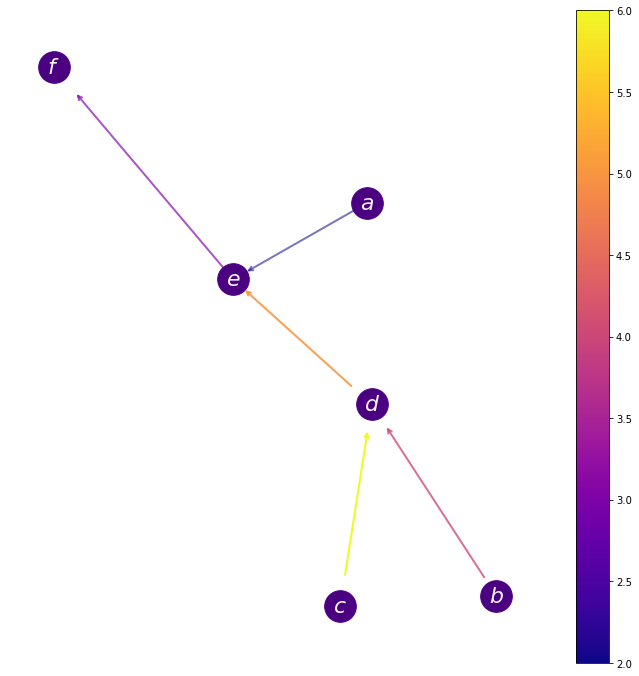

In [ ]:
M = G.number_of_edges()
node_sizes = [3 + 1000 * i for i in range(len(G))]
seed=42
pos = nx.spring_layout(G, seed=seed)
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)

for i in range(M):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

labels = {}
labels[1] = r"$a$"
labels[2] = r"$b$"
labels[3] = r"$c$"
labels[4] = r"$d$"
labels[5] = r"$e$"
labels[6] = r"$f$"
nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="whitesmoke")

ax = plt.gca()
ax.set_axis_off()
plt.show()